# 1. 이미지 잠재 공간에서 샘플링하기

- GAN과 VAE는 이미지 잠재 공간 표현을 학습하는 2가지 전략이고 각각 나름의 특징을 가집니다. VAE는 구조적인 잠재 공간을 학습하는 데 뛰어납니다. GAN은 매우 실제 같은 이미지를 만듭니다.

# 2. 이미지 변형을 위한 개념 벡터

- 잠재 공간이나 임베딩 공간이 주어지면 이 공간의 어떤 방향은 원본 데이터의 흥미로운 변화를 인코딩한 축일 수 있습니다. 예를 들어 얼굴 이미지에 대한 잠재 공간의 z + s 포인트는 같은 얼굴이 웃고 있는 표현을 임베딩한 것이다. 이런 벡터를 찾아내면 이미지를 잠재 공간에 투영해서 의미 있는 방향으로 이 표현을 이동한 후 이미지 공간으로 디코딩하여 복원하면 변형된 이미지를 얻을 수 있습니다. 기본적으로 이미지 공간에서 독립적으로 변화가 일어나는 모든 차원이 개념 벡터이다.

# 3. 변이형 오토인코더

- 변이형 오토인코더는 딥러닝과 베이즈 추론의 아이디어를 혼합한 오토인코더의 최신 버전입니다.


- 현실적으로 이런 전통적인 오토인코더는 특별히 유용하거나 구조화가 잘된 잠재 공간을 만들지 못합니다. 압축도 아주 뛰어나지 않습니다. 이런 이유 때문에 시대의 흐름에서 대부분 멀어졌습니다. VAE는 오토인코더에 약간의 통계 기법을 추가하여 연속적이고 구조적인 잠재 공간을 학습하도록 만들었습니다. 결국 이미지 생성을 위한 강력한 도구로 탈바꿈했습니다.


- 입력 이미지를 잠재 공간의 고정된 코딩으로 압축하는 대신 VAE는 이미지를 어떤 통계 분포의 파라미터로 변환합니다. 이는 입력 이미지가 통계적 과정을 통해서 생성되었다고 가정하여 인코딩과 디코딩하는 동안 무작위성이 필요하다는 것을 의미합니다. VAE는 평균과 분산 파라미터를 사용하여 이 분포에서 무작위로 하나의 샘플을 추출합니다. 이 샘플을 디코딩하여 원본 입력으로 복원합니다. 이런 무작위한 과정은 안전성을 향상하고 잠재 공간 어디서든 의미 있는 표현을 인코딩하도록 만듭니다. 즉 잠재 공간에서 샘플링한 모든 포인트는 유효한 출력으로 디코딩 됩니다.



### VAE

1. 인코더 모듈이 입력 샘플 input_img를 잠재 공간의 두 파라미터 z_mean, z_log_var로 변환합니다.

2. 입력 이미지가 생성되었다고 가정한 잠재 공간의 정규 분포에서 포인트 z를 z_mean + exp(0.5 * z_log_var) * epsilon처럼 무작위로 샘플링합니다. epsilon은 작은 값을 가진 랜덤 텐서입니다.

3. 디코더 모듈은 잠재 공간의 이 포인트를 원본 이미지로 매핑하여 복원합니다.

- epsilon이 무작위로 만들어지기 때문에 input_img를 인코딩한 잠재 공간의 위치(z_mean)에 가까운 포인트는 input_img와 비슷한 이미지로 디코딩 될 것입니다. 이는 잠재 공간을 연속적이고 의미 있는 공간으로 만들어줍니다. 잠재 공간에서 가까운 2개의 포인트는 아주 비슷한 이미지로 디코딩될 것입니다. 잠재 공간의 이런 저차원 연속성은 잠재 공간에서 모든 방향이 의미 있는 데이터 변화의 축을 인코딩하도록 만듭니다. 결국 잠재 공간은 매우 구조적이고 개념 벡터로 다루기에 적합해집니다.

- VAE 파라미터는 2개의 손실 함수로 훈련합니다. 디코딩된 샘플이 원본 입력과 동일하도록 만드는 재구성 손실과 잠재 공간을 잘 형성하고 훈련 데이터에 과대적합을 줄이는 규제 손실(regularization)입니다.

In [1]:
# 입력과 평균을 분산 파라미터로 인코딩합니다.
# z_mean, z_log_var = encoder(input_img)

# 무작위로 선택한 작은 epsilon 값을 사용하여 잠재 공간의 포인트를 뽑습니다.
# z = z_mean + exp(0.5 * z_log_var) * epsilon

# z 를 이미지로 디코딩합니다.
# reconsructed_img = decoder(z) - z를 이미지로 디코딩합니다

# 입력 이미지와 재구성 이미지를 매핑한 오토인코더 모델 객체를 만듭니다.
# model = Model(input_img, reconstructed_img)

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = False

config.gpu_options.per_process_gpu_memory_fraction = 0.2
set_session(tf.Session(config=config))

from keras.models import load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras import layers
from keras.models import Model
from keras import backend as K
from keras import optimizers
import keras

# img_shape = ()

## 1. VAE 인코더 네트워크

In [4]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim= 2 # 잠재 공간의 차원: 2D 평면

In [6]:
input_img = Input(shape=img_shape)

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same', activation='relu', strides=(2,2))(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

- z_mean, z_log_var을 사용하는 코드이다. 이 두 파라미터가 input_img를 생성한 통계 분포의 파라미터라 가정하고 잠재 공간 z를 생성한다. 여기에서 일련의 코드를 Lambda 층으로 감쌉니다. 케라스에서는 모든 것이 층이므로 기본 층을 사용하지 않는 코드는 Lambda로 감싸야 합니다. (케라스의 layers.Lambda 클래스는 임의의 함수 객체를 케라스 층으로 만들어줍니다.)

## 2. 잠재 공간 샘플링

In [7]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [8]:
z = layers.Lambda(sampling)([z_mean, z_log_var])

## 3. 잠재 공간 포인트를 이미지로 매핑하는 VAE 디코더

- 벡터 z를 이전 특성 맵 차원으로 크기를 바꾸고 몇 개의 합성곱 층을 사용하여 최종 출력 이미지를 만듭니다. 최종 이미지는 원본 input_img와 차원이 같습니다.

In [14]:
# input을 z에 주입한다.
decoder_input = layers.Input(K.int_shape(z)[1:])

# 입력을 업셈플링한다.
# 14 * 14 * 64
x = layers.Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

# 인코더 모델의 마지막 Flatten 층 직전의 특성 맵과 같은 크기의 특성 맵으로 z 크기를 바꾼다.
# (14, 14, 64)
x = layers.Reshape(shape_before_flattening[1:])(x)

# Conv2DTranspose 층과 Conv2D 층을 사용하여 z를 원본 입력 이미지와 같은 크기의 특성 맵으로 디코딩합니다.
# (28, 28, 32)
x = layers.Convolution2DTranspose(32, 3, padding='same', activation='relu', strides=(2,2))(x)

# (28, 28, 1)
x = layers.Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# decoder_input을 디코딩 된 이미지로 변환하는 디코더 모델 객체로 만든다.
decoder = Model(decoder_input, x)
z_decoded = decoder(z)

## 4. Loss 정의

- 일반적인 샘플 기준 함수인 loss(y_true, y_pred) 형태는 VAE 이중 손실에 맞지 않습니다. add_loss 내장 메서드를 사용하는 층을 만들어 임의의 손실을 정의한다.

In [26]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # regularization loss
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)
    
    # call 메서드가 있는 층을 구현한다.
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        
        # 이 출력을 사용하지는 않지만 층은 무엇인가를 반환해야 한다.
        return x

In [27]:
# 입력과 디코딩 출력으로 이 층을 호출하여 모델의 최종 출력을 얻는다.
y = CustomVariationalLayer()([input_img, z_decoded])

## 5. Training

In [28]:
from keras.datasets import mnist

In [29]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Output "custom_variational_layer_4" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_4" during training.
  


In [30]:
(x_train, _), (x_test, y_test) = mnist.load_data('mnist.npz')

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

In [31]:
print(x_train.shape, x_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


In [32]:
vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 32s 537us/step - loss: 0.2200 - val_loss: 0.2005
Epoch 2/10
60000/60000 [==============================] - 31s 514us/step - loss: 0.1983 - val_loss: 0.1947
Epoch 3/10
60000/60000 [==============================] - 29s 484us/step - loss: 0.1931 - val_loss: 0.1911
Epoch 4/10
60000/60000 [==============================] - 28s 473us/step - loss: 0.1901 - val_loss: 0.1877
Epoch 5/10
60000/60000 [==============================] - 29s 487us/step - loss: 0.1880 - val_loss: 0.1855
Epoch 6/10
60000/60000 [==============================] - 28s 471us/step - loss: 0.1861 - val_loss: 0.1856
Epoch 7/10
60000/60000 [==============================] - 29s 480us/step - loss: 0.1848 - val_loss: 0.1837
Epoch 8/10
60000/60000 [==============================] - 29s 477us/step - loss: 0.1837 - val_loss: 0.1835
Epoch 9/10
60000/60000 [==============================] - 29s 485us/step - loss: 0.1828 - val_

## 6. 2D 잠재 공간에서 포인트 그리드를 샘플링하여 이미지로 디코딩하기

In [33]:
import matplotlib.pyplot as plt
from scipy.stats import norm

In [35]:
n = 15
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# ppf는 cdf 함수와 반대이다. 백분위 수를 전달하면 해당 포인트 값을 반환한다.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

In [37]:
grid_x.shape, grid_y.shape

((15,), (15,))

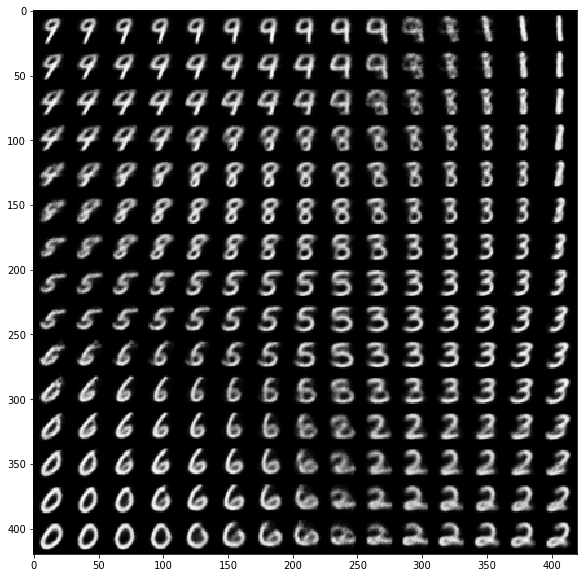

In [41]:
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        
        # np.tile은 입력 값을 반복하여 늘린다.
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

- 샘플링된 숫자의 그리드는 다른 숫자 클래스 사이에서 완벽하게 연속된 분포를 보여줍니다. 잠재 공간의 한 경로를 따라서 한 숫자가 다른 숫자로 자연스럽게 바뀝니다. 이 공간의 특정 방향은 어떤 의미를 가집니다. 예를 들어서 '6'으로 가는 방향 '9'로 가는 방향 등입니다.

## 7. 정리

1. 딥러닝으로 이미지 데이터셋에 대한 통계 정보를 담은 잠재 공간을 학습하여 이미지를 생성할 수 있습니다. 잠재 공간에서 포인트를 샘플링하고 디코딩하면 이전에 본적 없는 이미지를 생성한다. 이를 수행하는 주요 방법은 VAE와 GAN입니다.

2. VAE는 매우 구조적이고 연속적인 잠재 공간의 표현을 만듭니다. 이런 이유로 잠재 공간 안에서 일어나는 모든 종류의 이미지 변형 작업에 잘 맞습니다. 다른 얼굴로 바꾸기, 찌푸린 얼굴을 웃는 얼굴로 변형하기 등입니다. 잠재 공간을 가로질러 이미지가 변환하는 잠재 공간 기반의 애니메이션에도 잘 맞습니다. 시작 이미지가 연속적으로 다른 이미지로 부드럽게 바뀌는 것을 볼 수 있습니다.

3. GAN은 실제 같은 이미지를 생성할 수 있지만 구조적이고 연속적인 공간을 만들지 못합니다.